In [18]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.models import resnet18
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

cuda:0


In [19]:

TRAIN_PATH ="garbage_data/garbage_data/CVPR_2024_dataset_Train"
VAL_PATH ="garbage_data/garbage_data/CVPR_2024_dataset_Val"
TEST_PATH ="garbage_data/garbage_data/CVPR_2024_dataset_Test"


In [20]:
# Transforms 
torchvision_transform = transforms.Compose([transforms.Resize((224,224)),\
    transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225] )])


torchvision_transform_test = transforms.Compose([transforms.Resize((224,224)),\
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225])])


# Load datasets
train_dataset = ImageFolder(root=TRAIN_PATH, transform= torchvision_transform)
val_dataset = ImageFolder(root=VAL_PATH, transform= torchvision_transform)
test_dataset = ImageFolder(root=TEST_PATH, transform= torchvision_transform_test)

# Define batch size and number of workers (adjust as needed)
batch_size = 32
num_workers = 0

# Create data loaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [21]:
class_names = train_dataset.classes
print(class_names)
print("Train set:", len(trainloader)*batch_size)
print("Val set:", len(valloader)*batch_size)
print("Test set:", len(testloader)*batch_size)

['Black', 'Blue', 'Green', 'TTR']
Train set: 11648
Val set: 1824
Test set: 3456


In [22]:
train_iterator = iter(trainloader)
train_batch = next(train_iterator)

In [23]:
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6291069].


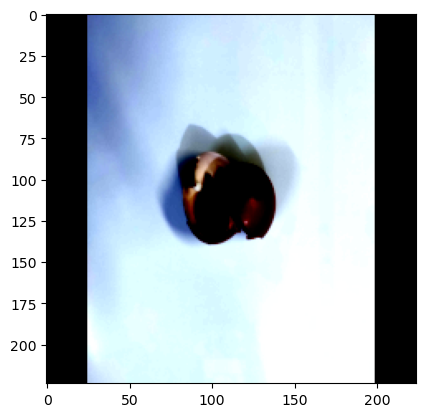

In [24]:
plt.figure()
plt.imshow(train_batch[0].numpy()[16].transpose(1,2,0))
plt.show()

In [25]:
class GarbageModel(nn.Module):
    def __init__(self,  num_classes, input_shape, transfer=False):
        super().__init__()

        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape
        
        # transfer learning if weights=True
        self.feature_extractor = models.resnet18(weights=transfer)

        if self.transfer:
            # layers are frozen by using eval()
            self.feature_extractor.eval()
            # freeze params
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        n_features = self._get_conv_output(self.input_shape)
        self.classifier = nn.Linear(n_features, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self.feature_extractor(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    # will be used during inference
    def forward(self, x):
       x = self.feature_extractor(x)
       x = x.view(x.size(0), -1)
       x = self.classifier(x)
       
       return x

In [26]:
net = GarbageModel(4, (3,224,224), True)
net.to(device)

GarbageModel(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [27]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [28]:
nepochs = 20
PATH = './garbage_net.pth' # Path to save the best model

best_loss = 1e+20
for epoch in range(nepochs):  # loop over the dataset multiple times
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end = ' ')
    scheduler.step()
    
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
        print(f'val loss: {val_loss / i:.3f}')
        
        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss
        
print('Finished Training')

1,  train loss: 0.891, val loss: 0.823
Saving model
2,  train loss: 0.789, val loss: 0.824
3,  train loss: 0.751, val loss: 0.778
Saving model
4,  train loss: 0.742, val loss: 0.795
5,  train loss: 0.737, val loss: 0.765
Saving model
6,  train loss: 0.720, val loss: 0.734
Saving model
7,  train loss: 0.722, val loss: 0.805
8,  train loss: 0.718, val loss: 0.756
9,  train loss: 0.694, val loss: 0.774
10,  train loss: 0.693, val loss: 0.722
Saving model
11,  train loss: 0.684, val loss: 0.742
12,  train loss: 0.678, val loss: 0.732
13,  train loss: 0.673, val loss: 0.710
Saving model
14,  train loss: 0.665, val loss: 0.708
Saving model
15,  train loss: 0.670, val loss: 0.721
16,  train loss: 0.661, val loss: 0.720
17,  train loss: 0.662, val loss: 0.688
Saving model
18,  train loss: 0.658, val loss: 0.701
19,  train loss: 0.653, val loss: 0.688
20,  train loss: 0.652, val loss: 0.713
Finished Training
